In [29]:
# import block
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
from astropy.visualization import hist
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D
from astropy.nddata import CCDData
phot_tutorial_dir = '/Users/levischult/Desktop/classes/ccd-reduction-and-photometry-guide/notebooks/'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

# import block
# some of these may not be needed
import numpy as np
from astropy.io import fits
import pdb
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib
from astropy.visualization import hist
from datetime import datetime
from pathlib import Path
import os
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D, Gaussian1D,Gaussian2D,Polynomial2D
from astropy.modeling import fitting
from astropy.stats import mad_std
from astropy.nddata import CCDData, StdDevUncertainty
from scipy import stats
from astropy import units as u
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.table import Table

from astropy.coordinates import SkyCoord

In [2]:
# import convenience plotting functions downloaded from 
# here: https://github.com/mwcraig/ccd-reduction-and-photometry-guide
phot_tutorial_dir = '/Users/levischult/Desktop/classes/ccd-reduction-and-photometry-guide/notebooks/'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [3]:
# for imaging, I like the photometry notebook plot defaults
# so use their custom style for larger fonts and figures
plt.style.use('/Users/levischult/Desktop/classes/ccd-reduction-and-photometry-guide/notebooks/guide.mplstyle')

# set a couple more default parameters for the plots below
rc('font', size=20)
rc('axes', grid=True)

In [4]:
data_dir = '/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/imagedataset/'            # raw data directory
reduced_dir = '/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/reduced/' # reduced working directory

In [43]:
imgs = ImageFileCollection(reduced_dir, glob_include='*ottzf.fits')

In [30]:
! cat /Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/imagedataset/log.txt

2009 June 22 local (23rd UT)
Observer: Kobulnicky, J. Runnoe, J. Dornfeld
Clearish, 55F, Humidity 56%
Winds 020 @ 10 mph
Image	Object		exp	Filt	UT	Notes
a005-10	SkyFlats	1	Halpha	
11-14			2	Halpha
15-20			3	Halpha
21			3	U		saturated
22			3	U
23-28			3	U		
29			3	B		     saturated
30			3	B		     saturated
31			3	B		     saturated
32			1	B		     30,000 cts
33			2	B		     
34			3	B		     saturated?
35			3	B	3:13	     
36			3	B	
37			3	B		
38			3	B	
39			4	B	previously not tracking; now tracking
40			5	B    
41			6	B
42			6	B	
43			3	V	3:21
44			6	V	
45			12	V
46			12	V
47			20	V
48			20	V
49			20	V
50			15	R
51			20	R
52			25	R
53			30	R
54			40	R
55			50	R
56			50	I   bad
57			50	I
58			80	I
59			120	I
60			120	I
61			200	I
62			200	I
63 bad
64 focus PG1633+099	2	V	focus=0   3.9 pix fwhm
65 focus			V	focus=200 3.4
66 focus			V	focus=400 5.7
67 focus			V	focus=400 again 6.6 worse!
68 focus			V	focus=250  4.4
69				V	focus=100  3.3
70				V	focus=0	   3.7
71				V	focus=-100 3.1
72				V	foc

# 1

In [50]:
linearity_tst_imgs = imgs.files_filtered(filter='V', include_path=True)[10:17]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


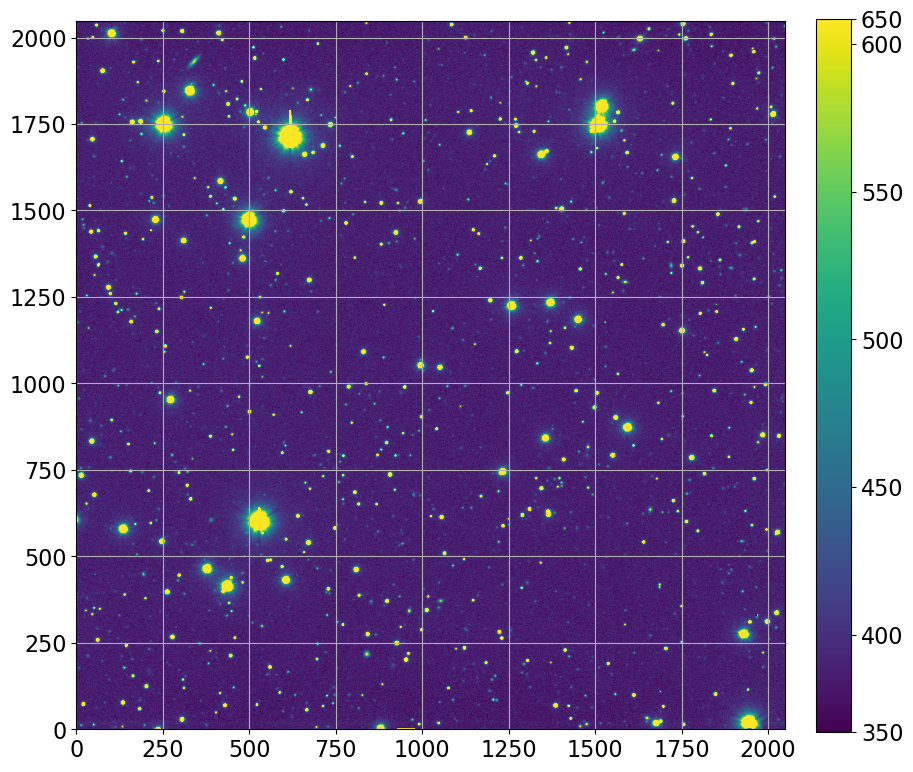

In [270]:
show_image(CCDData.read(linearity_tst_imgs[-2], unit='adu'))

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


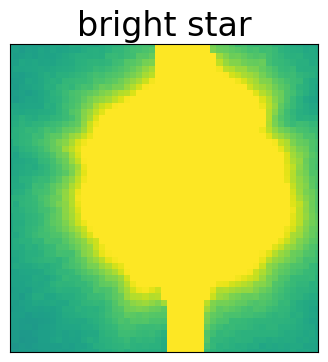

In [271]:
brightstarpos = (613, 1709)

img = np.array(CCDData.read(linearity_tst_imgs[-1], unit='adu'))
imgmn = img.mean()
imgstd = img.std()
min_level = imgmn - imgstd
max_level = imgmn + imgstd
fig = plt.subplots(1,1,figsize=(4,4))
plt.imshow(img, vmin=min_level, vmax=max_level)
# for ap in aperturelist:
#     ap.plot()
plt.xticks([])
plt.yticks([])
# plt.xlim(right=1600)
# plt.ylim(top=500)
plt.xlim(brightstarpos[0]-25, brightstarpos[0]+25)
plt.ylim(brightstarpos[1]-25, brightstarpos[1]+25)
plt.title('bright star')
plt.grid(False)
plt.show()

In [266]:
maxcounts = []
exptim = [2, 4, 8, 16, 32, 64, 128]

for idx, img in enumerate(linearity_tst_imgs):
    maxcounts.append(np.max(np.array(CCDData.read(img, unit='adu'))[brightstarpos[0]-25:brightstarpos[0]+25, brightstarpos[1]-25:brightstarpos[1]+25]))

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [53]:
2**16

65536

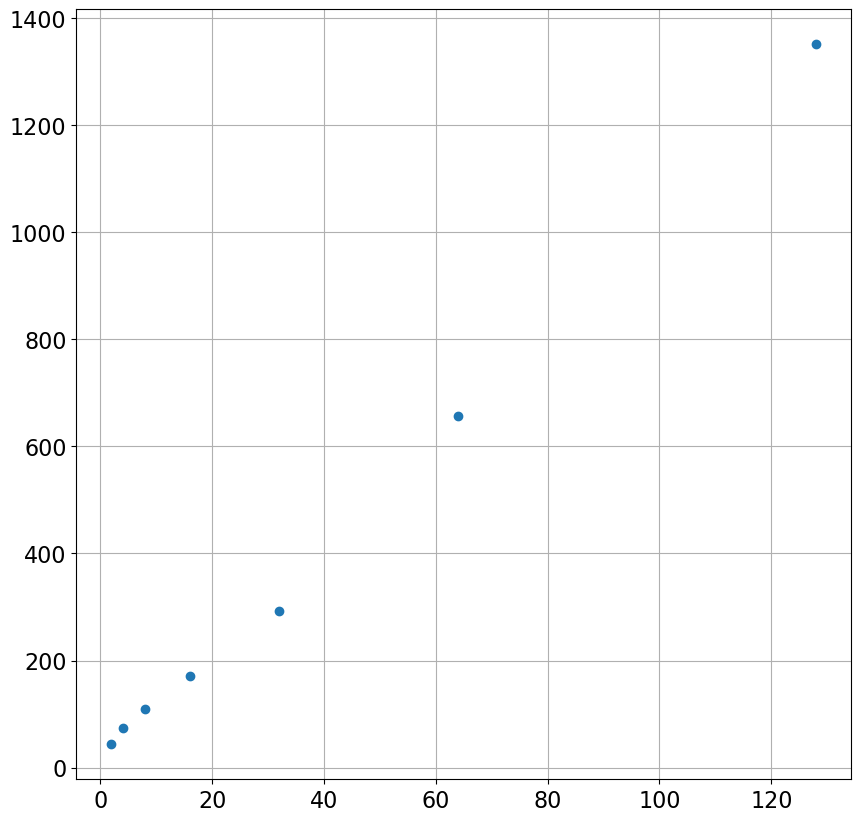

In [268]:
plt.scatter(exptim, maxcounts)
# plt.xscale('log')
# plt.yscale('log')

# 2

In [253]:
pg16_std_img = imgs.files_filtered(imagetyp='PG1633+099', include_path=True)[17]
print(pg16_std_img)

/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/reduced/a081_ottzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/reduced/a081_ottzf.fits
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


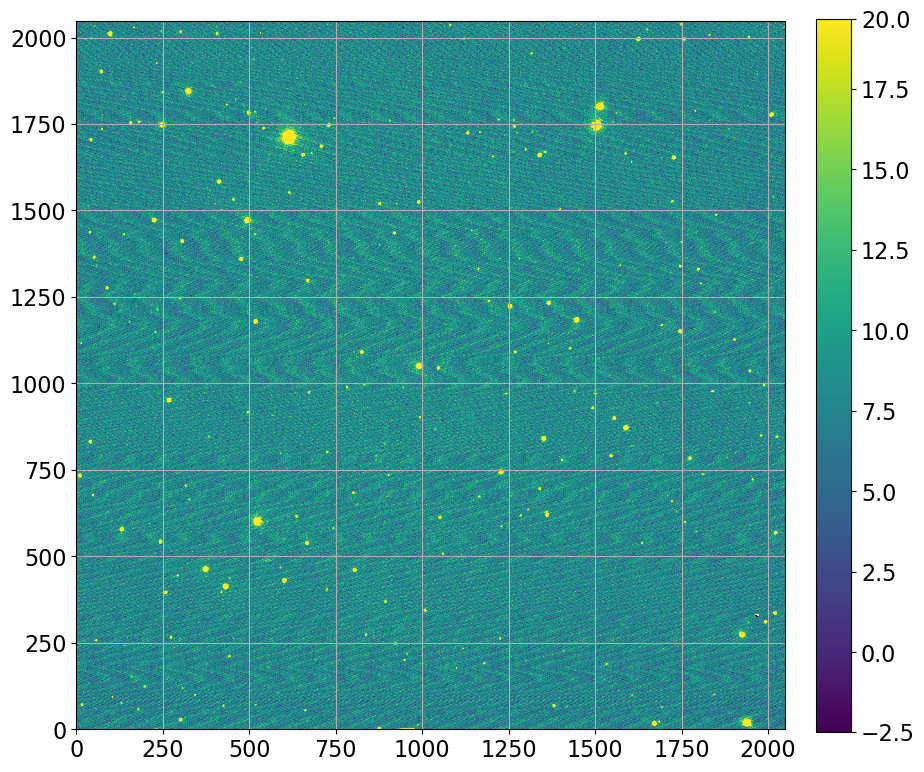

In [65]:
print(pg16_std_img)
show_image(CCDData.read(pg16_std_img, unit='adu'))

In [272]:
hdu = fits.open(pg16_std_img)
hdr = hdu[0].header
img = hdu[0].data
#show_image(img)

* locations picked in DS9 and refined in python

In [148]:
x1 = 919 #faint
x2 = 518 #medium
x3 = 613 #bright

y1 = 1432
y2 = 1177
y3 = 1709

positions = [(x1,y1),(x2,y2),(x3,y3)]

In [149]:
aperture1 = CircularAperture(positions, r=1.0)
aperture2 = CircularAperture(positions, r=3.0)
aperture3 = CircularAperture(positions, r=9.0)
aperture4 = CircularAperture(positions, r=17.0)
aperture5 = CircularAperture(positions, r=25.0)

aperturelist = [aperture1, aperture2, aperture3, aperture4, aperture5]

* plotting all the apertures

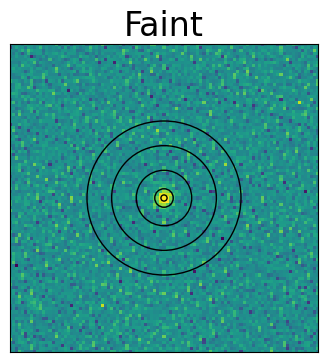

In [157]:
imgmn = img.mean()
imgstd = img.std()
min_level = imgmn - imgstd
max_level = imgmn + imgstd
fig = plt.subplots(1,1,figsize=(4,4))
plt.imshow(img, vmin=min_level, vmax=max_level)
for ap in aperturelist:
    ap.plot()
plt.xticks([])
plt.yticks([])
# plt.xlim(right=1600)
# plt.ylim(top=500)
plt.xlim(positions[0][0]-50, positions[0][0]+50)
plt.ylim(positions[0][1]-50, positions[0][1]+50)
plt.title('Faint')
plt.grid(False)
plt.show()

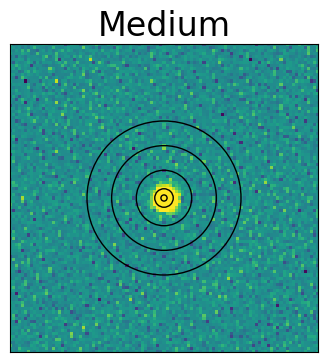

In [158]:
imgmn = img.mean()
imgstd = img.std()
min_level = imgmn - imgstd
max_level = imgmn + imgstd
fig = plt.subplots(1,1,figsize=(4,4))
plt.imshow(img, vmin=min_level, vmax=max_level)
for ap in aperturelist:
    ap.plot()
plt.xticks([])
plt.yticks([])
# plt.xlim(right=1600)
# plt.ylim(top=500)
plt.xlim(positions[1][0]-50, positions[1][0]+50)
plt.ylim(positions[1][1]-50, positions[1][1]+50)
plt.title('Medium')
plt.grid(False)
plt.show()

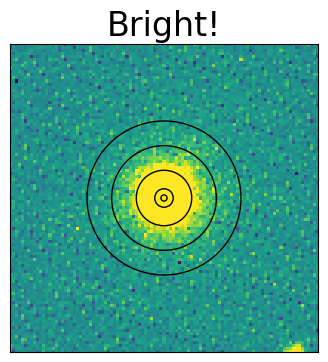

In [159]:
imgmn = img.mean()
imgstd = img.std()
min_level = imgmn - imgstd
max_level = imgmn + imgstd
fig = plt.subplots(1,1,figsize=(4,4))
plt.imshow(img, vmin=min_level, vmax=max_level)
for ap in aperturelist:
    ap.plot()
plt.xticks([])
plt.yticks([])
# plt.xlim(right=1600)
# plt.ylim(top=500)
plt.xlim(positions[2][0]-50, positions[2][0]+50)
plt.ylim(positions[2][1]-50, positions[2][1]+50)
plt.title('Bright!')
plt.grid(False)
plt.show()

* Total Signal!

In [199]:
S = np.zeros((3, 5)) # position x aperture_sum
phot_tbl_list = [1, 2, 3, 4, 5] # placeholders

for idx, ap in enumerate(aperturelist):
    print(f'aperture radius={ap.r}')
    phot_table = aperture_photometry(img, ap)
    phot_tbl_list[idx] = phot_table
    phot_table['aperture_sum'].info.format = '%.8g'
    S[:, idx] = np.array(phot_table['aperture_sum'])
    print(phot_table)

aperture radius=1.0
 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   919.0  1432.0    201.85996
  2   518.0  1177.0    1405.1295
  3   613.0  1709.0    72040.739
aperture radius=3.0
 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   919.0  1432.0    1249.4643
  2   518.0  1177.0    7773.4949
  3   613.0  1709.0     412428.1
aperture radius=9.0
 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   919.0  1432.0    3592.9107
  2   518.0  1177.0    13684.912
  3   613.0  1709.0    674141.39
aperture radius=17.0
 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   919.0  1432.0    8792.5175
  2   518.0  1177.0    19234.304
  3   613.0  1709.0    701323.09
aperture radius=25.0
 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   9

* aperture area

In [160]:
for ap in aperturelist:
    print(f'aperture r={ap.r} area={ap.area}')

aperture r=1.0 area=3.141592653589793
aperture r=3.0 area=28.274333882308138
aperture r=9.0 area=254.46900494077323
aperture r=17.0 area=907.9202768874502
aperture r=25.0 area=1963.4954084936207


In [194]:
ring_B_f = CircularAnnulus(positions, r_in=aperture2.r, r_out=aperture3.r) #faint 
ring_B_m = CircularAnnulus(positions, r_in=aperture3.r, r_out=aperture4.r) #medium
ring_B_b = CircularAnnulus(positions, r_in=aperture4.r, r_out=aperture5.r) #bright!

# testing if I can just do the very last annulus as a background for all of them
ring_B_con = CircularAnnulus(positions, r_in=aperture5.r, r_out=aperture5.r+10)

phot_B_table_f = aperture_photometry(img, ring_B_f)
phot_B_table_m = aperture_photometry(img, ring_B_m)
phot_B_table_b = aperture_photometry(img, ring_B_b)

phot_B_table_con = aperture_photometry(img, ring_B_con)

B_f = float(phot_B_table_f['aperture_sum'][0]) / ring_B_f.area
B_m = float(phot_B_table_m['aperture_sum'][1]) / ring_B_m.area
B_b = float(phot_B_table_b['aperture_sum'][2]) / ring_B_b.area

B_con = np.float16(phot_B_table_con['aperture_sum']) / ring_B_con.area

* seeing that backgrounds are roughly equivalent

In [195]:
print(f'{B_f=}')
print(f'{B_m=}')
print(f'{B_b=}')
print(B_con)

B_f=10.360307546719273
B_m=8.492435476222566
B_b=17.507309821902187
aperture_sum
------------
        8.59
        8.55
      11.875


* this is close enough for me I think. Using constant ring also seems to have a more even background across the three stars
* calculating instrumental mag

In [204]:
phot_tbl_list

[<QTable length=3>
   id  xcenter ycenter aperture_sum
         pix     pix               
 int64 float64 float64   float64   
 ----- ------- ------- ------------
     1   919.0  1432.0    201.85996
     2   518.0  1177.0    1405.1295
     3   613.0  1709.0    72040.739,
 <QTable length=3>
   id  xcenter ycenter aperture_sum
         pix     pix               
 int64 float64 float64   float64   
 ----- ------- ------- ------------
     1   919.0  1432.0    1249.4643
     2   518.0  1177.0    7773.4949
     3   613.0  1709.0     412428.1,
 <QTable length=3>
   id  xcenter ycenter aperture_sum
         pix     pix               
 int64 float64 float64   float64   
 ----- ------- ------- ------------
     1   919.0  1432.0    3592.9107
     2   518.0  1177.0    13684.912
     3   613.0  1709.0    674141.39,
 <QTable length=3>
   id  xcenter ycenter aperture_sum
         pix     pix               
 int64 float64 float64   float64   
 ----- ------- ------- ------------
     1   919.0  1432.

In [232]:
ins_m = np.zeros((5, 3)) # positions x apertures
s_n = np.zeros((5,3)) # signal to noise array S / A*B
for idx, ap in enumerate(aperturelist):
    ins_m[idx, :] = -2.5 * np.log10(phot_tbl_list[idx]['aperture_sum'] - ap.area*B_con)
    s_n[idx, :] = (phot_tbl_list[idx]['aperture_sum'] - ap.area*B_con) / ap.area*B_con

In [233]:
ins_m

array([[ -5.60682298,  -7.8483482 , -12.14338338],
       [ -7.50699599,  -9.69223901, -14.03748637],
       [ -7.86912181, -10.15258565, -14.56699946],
       [ -7.48746095, -10.14931592, -14.59797067],
       [ -7.56552104, -10.12314825, -14.60728935]])

In [234]:
s_n

array([[4.78367906e+02, 3.74970205e+03, 2.72168022e+05],
       [3.05906517e+02, 2.27672499e+03, 1.73075576e+05],
       [4.74456659e+01, 3.86550927e+02, 3.13183239e+04],
       [9.35662834e+00, 1.08015482e+02, 9.03179710e+03],
       [4.64901814e+00, 4.87569761e+01, 4.21230171e+03]])

Text(0.5, 0, 'Aperture Radius (pixels)')

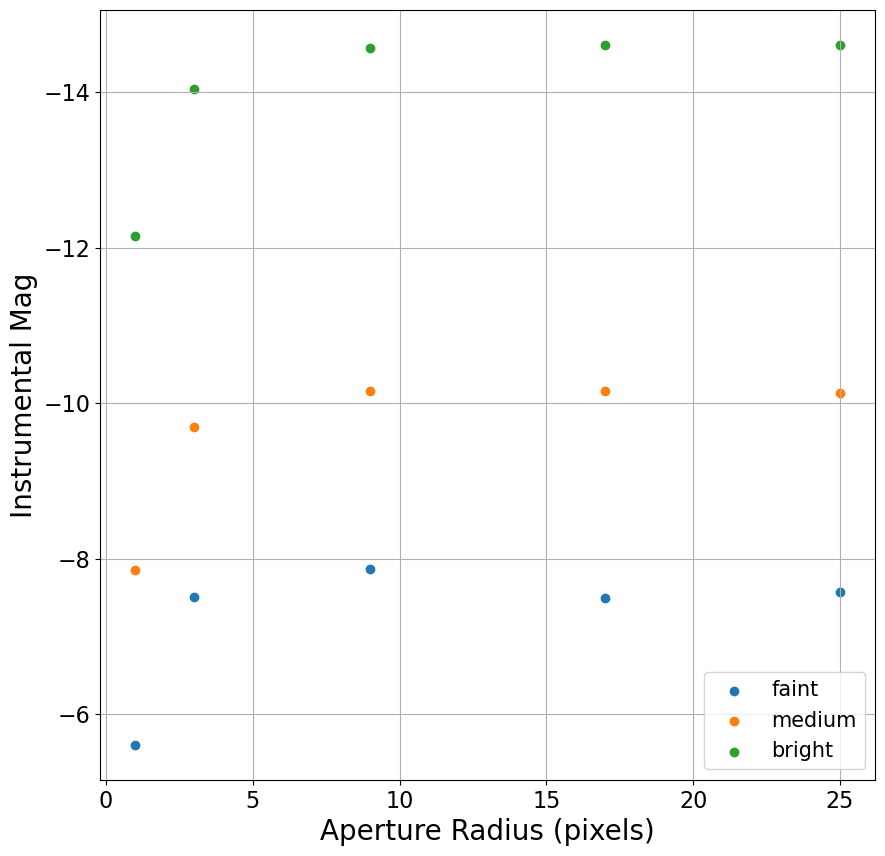

In [231]:
ap_r = [ap.r for ap in aperturelist]
strbrightlbl = ['faint', 'medium', 'bright']
for idx in range(3):
    plt.scatter(ap_r, ins_m[:, idx], label=strbrightlbl[idx])
plt.gca().invert_yaxis()
plt.legend(fontsize=15)
plt.ylabel('Instrumental Mag')
plt.xlabel('Aperture Radius (pixels)')


In [250]:
radiuslbls = [str(r) for r in ap_r]

Text(0.5, 0, 'Aperture Radius (pixels)')

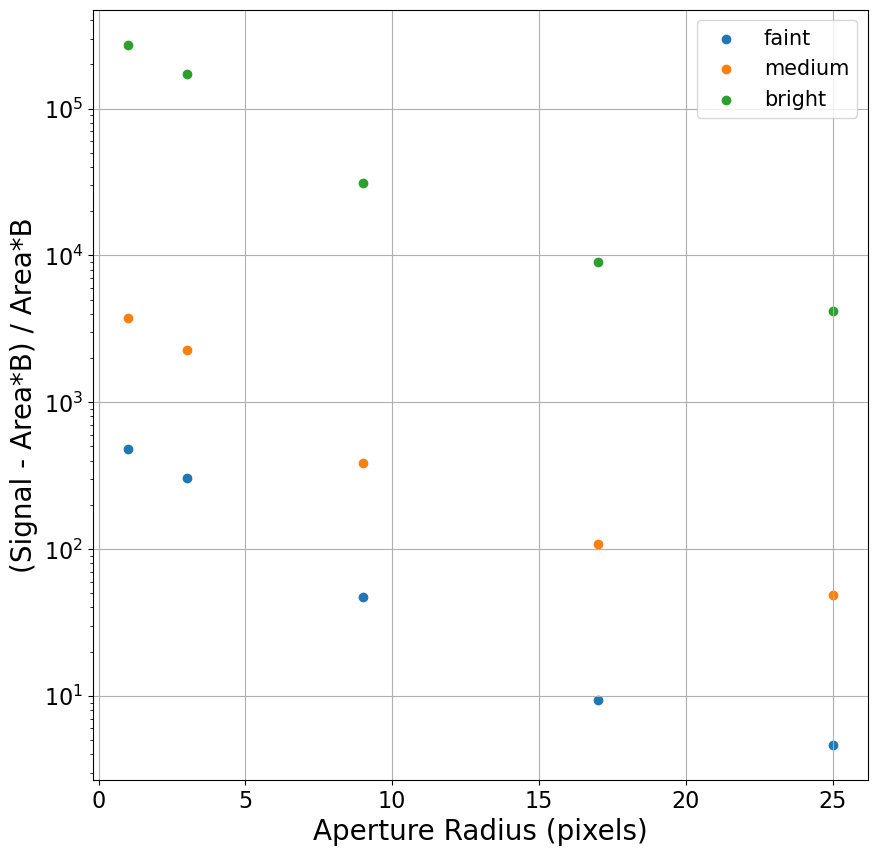

In [251]:
for idx in range(3):
    plt.scatter(ap_r, s_n[:, idx], label=strbrightlbl[idx])
plt.legend(fontsize=15)
plt.yscale('log')
plt.ylabel('(Signal - Area*B) / Area*B')
plt.xlabel('Aperture Radius (pixels)')

* from the above plots of the star's magnitude and signal-to-noise as a function\
of aperture, it seems like the third aperture is an appropriate compromise between\
s/n and accurate magnitude. The stellar magnitudes plateau after the third aperture\
(the dimmest star has some fluctuation), and the s/n decreases quite a lot with\
the other larger apertures. An aperture between the second and third might be\
good as well, but I think the third (r= 9 px)

# 3 + 4

* going to use the r=9px as a fwhm for the star identification

In [345]:
def get_phot(filename, use_fwhm=9.0, ap_rad=9.0):
    # load file
    hdu = fits.open(filename)
    hdr = hdu[0].header
    img = hdu[0].data
    # do stats
    mean, median, std = sigma_clipped_stats(img, sigma=3.0)
    # find stars
    daofind = DAOStarFinder(fwhm=use_fwhm, threshold=5.*std)  
    sources = daofind(img - median)  
    for col in sources.colnames:  
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f'  # for consistent table output
    # make apertures
    xcent = np.array(sources['xcentroid'])
    ycent = np.array(sources['ycentroid'])
    initpositions = []
    for idx in range(xcent.shape[0]):
        initpositions.append((xcent[idx], ycent[idx]))
    apertureinitpos = CircularAperture(initpositions, r=ap_rad)

    # plotting
    min_level = mean - std
    max_level = mean + std
    fig = plt.subplots(1,1,figsize=(6,6))
    plt.imshow(img, vmin=min_level, vmax=max_level)
    apertureinitpos.plot()
    plt.show()
    
    # do photometry
    phot_table = aperture_photometry(img, apertureinitpos)
    ring_B_con = CircularAnnulus(initpositions, r_in=25.0, r_out=35.0)
    phot_B_table_con = aperture_photometry(img, ring_B_con)
    B_con = np.float16(phot_B_table_con['aperture_sum']) / ring_B_con.area
    phot_table['ins_m'] = -2.5 * np.log10(phot_table['aperture_sum'] - apertureinitpos.area*B_con)

    return phot_table

/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/reduced/a081_ottzf.fits


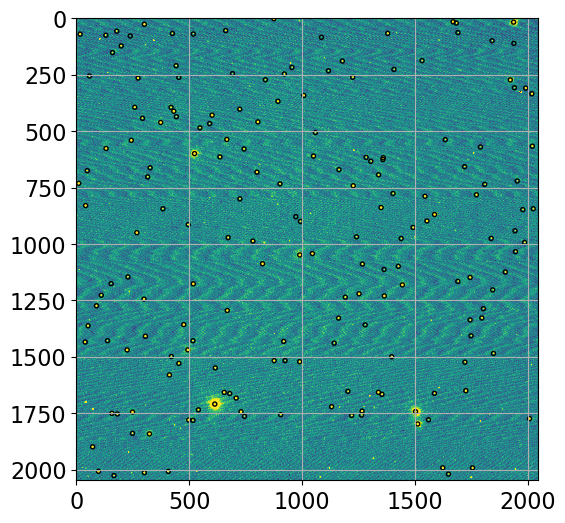

/var/folders/1y/5f87nyls7mnbqvgd2zgz0lmc0000gr/T/ipykernel_39349/1380746540.py:35: RuntimeWarning: invalid value encountered in log10
  phot_table['ins_m'] = -2.5 * np.log10(phot_table['aperture_sum'] - apertureinitpos.area*B_con)


In [346]:
print(pg16_std_img)
pg_std_phot = get_phot(pg16_std_img)

In [347]:
pg_std_phot

id,xcenter,ycenter,aperture_sum,ins_m
,pix,pix,,
int64,float64,float64,float64,float64
1,875.5807470134366,1.2575622518259288,4898.990735360652,-8.957994308559538
2,1670.3788455088886,15.095606755245614,15506.580374305622,-10.37816257484244
3,1938.4100647792689,16.55983274558529,190356.0273440362,-13.190988060312261
4,1684.1647805697944,20.746134214206496,2696.853486992414,-7.6563172250145275
5,301.8136940034483,26.259976916563655,4935.389459423777,-8.77044507069922
6,662.0150882394564,54.12544060739109,2558.83787095773,-6.862370333197915
7,179.34524244422926,56.6900388648039,2599.894374485011,-7.050330137958284
8,1691.5306853508282,63.16637458783218,2361.613949083283,-6.470998494094982


In [273]:
mean, median, std = sigma_clipped_stats(img, sigma=3.0)  
print((mean, median, std))  

(8.411880977496395, 8.273973134558787, 6.674083468301809)


In [274]:
daofind = DAOStarFinder(fwhm=9.0, threshold=5.*std)  
sources = daofind(img - median)  
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output

sources.pprint(max_width=76)  


 id xcentroid ycentroid sharpness roundness1 ... sky    peak   flux   mag 
--- --------- --------- --------- ---------- ... ---- ------- ------ -----
  1    875.58      1.26      0.83      -0.21 ... 0.00  211.03  12.27 -2.72
  2   1670.38     15.10      0.66      -0.00 ... 0.00  531.17  35.78 -3.88
  3   1938.41     16.56      0.60      -0.07 ... 0.00 6640.36 473.06 -6.69
  4   1684.16     20.75      0.63      -0.14 ... 0.00   28.41   2.04 -0.77
  5    301.81     26.26      0.70       0.05 ... 0.00  120.14   7.89 -2.24
  6    662.02     54.13      0.61      -0.17 ... 0.00   30.02   2.25 -0.88
  7    179.35     56.69      0.55       0.41 ... 0.00   18.94   1.53 -0.46
  8   1691.53     63.17      0.26      -0.36 ... 0.00    9.11   1.49 -0.44
  9    425.77     67.05      0.88       0.58 ... 0.00   30.85   1.72 -0.59
 10   1380.30     66.61      0.57      -0.14 ... 0.00   78.23   5.88 -1.92
...       ...       ...       ...        ... ...  ...     ...    ...   ...
173   1513.46   1797.96  

In [276]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,875.58,1.26,0.83,-0.21,-0.28,121,0.00,211.03,12.27,-2.72
2,1670.38,15.10,0.66,-0.00,-0.05,121,0.00,531.17,35.78,-3.88
3,1938.41,16.56,0.60,-0.07,-0.04,121,0.00,6640.36,473.06,-6.69
4,1684.16,20.75,0.63,-0.14,0.05,121,0.00,28.41,2.04,-0.77
5,301.81,26.26,0.70,0.05,0.03,121,0.00,120.14,7.89,-2.24
6,662.02,54.13,0.61,-0.17,0.01,121,0.00,30.02,2.25,-0.88
7,179.35,56.69,0.55,0.41,0.34,121,0.00,18.94,1.53,-0.46
8,1691.53,63.17,0.26,-0.36,-0.50,121,0.00,9.11,1.49,-0.44
9,425.77,67.05,0.88,0.58,0.13,121,0.00,30.85,1.72,-0.59
